## Imports

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns


# another way of ignoring warnings
warnings.filterwarnings('ignore')

#### Loading dataset

In [169]:
df_ = pd.read_csv("df_1hot.csv")
X = df_.iloc[:, 1:]
y = df_.iloc[:, 0]

#### Dealing with NaN values
##### Instead of filling NaN values with mean of the predictor, use KNN Imputer (Scikit-Learn).

This imputer utilizes the k-Nearest Neighbors method to replace the missing values in the datasets with the mean value from the parameter ‘n_neighbors’ nearest neighbors found in the training set. By default, it uses a Euclidean distance metric to impute the missing values.

Another critical point here is that the KNN Imptuer is a distance-based imputation method and it requires us to **normalize** our data. Otherwise, the different scales of our data will lead the KNN Imputer to generate biased replacements for the missing values. For simplicity, we will use Scikit-Learn’s MinMaxScaler which will scale our variables to have values between 0 and 1.

We are setting the parameter ‘n_neighbors’ as 5. So, the missing values will be replaced by the mean value of 5 nearest neighbors measured by Euclidean distance.

```python
scaler = MinMaxScaler()
df_ = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

imputer = KNNImputer(n_neighbors=5)
df_ = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
df.head(10)
```

In [170]:
def fill_NaNs_KNN(dataframe):
    X_cat = dataframe[[col for col in dataframe.columns if col.startswith('C_')]]
    X_cont = dataframe[[col for col in dataframe.columns if col.startswith('x_')]]

    ### 1. Fill NaN vlaues in continuous columns (X_cont)
    scaler = StandardScaler()
    scaled_X_cont = scaler.fit_transform(X_cont)
    knn_imputer = KNNImputer(n_neighbors=5)
    X_cont_imputed = knn_imputer.fit_transform(scaled_X_cont)
    X_cont_imputed = pd.DataFrame(X_cont_imputed, columns=X_cont.columns)

    ### 2. Fill NaN vlaues for the categorical columns (X_cat)
    #cat_imputer = SimpleImputer(strategy="most_frequent")
    #X_cat_imputed = cat_imputer.fit_transform(X_cat)
    #X_cat_imputed = pd.DataFrame(X_cat_imputed, columns=X_cat.columns)

    ### 4. 1-HOT-encoding of categorical columns
    #X_cat_imputed_1HOT = pd.get_dummies(X_cat_imputed, columns=X_cat_imputed.columns, drop_first=False).astype(int)
    
    ### 5. Merging y, X_con_imputed (standartized and NaN filled) and X_con_imputed_1HOT (NaN filled and relabelled, 1hotencoded)
    df_trans = pd.concat([X_cont_imputed.reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)

    return df_trans, df_trans.shape, scaler

def centerData_y(y):
    
    y_mu = np.mean(y,axis=0)
    y_centr = y - y_mu
    
    return y_centr, y_mu

def cont_cat(dataframe):
    X_cat = dataframe[[col for col in dataframe.columns if col.startswith('C_')]]
    X_cont = dataframe[[col for col in dataframe.columns if col.startswith('x_')]]

    return X_cont, X_cat

def align_columns(Xtrain, Xtest):
    # Find columns in Xtrain and Xtest
    missing_in_Xtrain = set(Xtest.columns) - set(Xtrain.columns)
    missing_in_Xtest = set(Xtrain.columns) - set(Xtest.columns)
    
    # Add missing columns to the respective DataFrames
    for col in missing_in_Xtrain:
        Xtrain[col] = np.nan  # or you can use 0 if preferred
    
    for col in missing_in_Xtest:
        Xtest[col] = np.nan  # or you can use 0 if preferred

    # Ensure columns are in the same order
    Xtrain = Xtrain[Xtest.columns]

    return Xtrain, Xtest

#### Data split

In [171]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

"""
# Handle missing values
Xtrain, shape, scaler = fill_NaNs_KNN(Xtrain)

# Preprocess test set using the same transformations
X_cont, X_cat = cont_cat(Xtest)
X_cont = pd.DataFrame(scaler.transform(X_cont), columns=X_cont.columns)
Xtest = pd.concat([X_cont.reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)
Xtest, ___, ___  = fill_NaNs_KNN(Xtest)

# Center the target variable
ytrain, y_mu = centerData_y(ytrain)
ytest = ytest - y_mu
"""

'\n# Handle missing values\nXtrain, shape, scaler = fill_NaNs_KNN(Xtrain)\n\n# Preprocess test set using the same transformations\nX_cont, X_cat = cont_cat(Xtest)\nX_cont = pd.DataFrame(scaler.transform(X_cont), columns=X_cont.columns)\nXtest = pd.concat([X_cont.reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)\nXtest, ___, ___  = fill_NaNs_KNN(Xtest)\n\n# Center the target variable\nytrain, y_mu = centerData_y(ytrain)\nytest = ytest - y_mu\n'

### Ridge Regression

In [172]:
ridge = Ridge()

# Define the hyperparameter grid
param_grid_ridge = {
    'alpha': np.logspace(-3, 1, 10)  # Removed extra '100' argument
}

# Use GridSearchCV **once** before the loop to avoid redundant computation
Ridge_ = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='r2', n_jobs=-1)
Ridge_.fit(Xtrain, ytrain)

print("Best parameters for Ridge: ", Ridge_.best_params_)
print("Best cross-validation score: {:.4f}".format(Ridge_.best_score_))

# Evaluate the best model on test data
best_model_ridge = Ridge_.best_estimator_
y_pred = best_model_ridge.predict(Xtest)

test_r2 = r2_score(ytest, y_pred)
print("R² score on test set: {:.4f}".format(test_r2))

Best parameters for Ridge:  {'alpha': 10.0}
Best cross-validation score: 0.6688
R² score on test set: 0.7512


In [173]:
# Initialize the Lasso model
ridge = Ridge()

# Define the hyperparameter grid for Lasso
param_grid_lasso = {
    'alpha': np.logspace(-3, 1, 10)  # Fixed logspace range
}

# Set up the grid search with 5-fold cross-validation
Ridge_ = GridSearchCV(ridge, param_grid_lasso, cv=5, scoring='r2')

# Fit the grid search to your training data
Ridge_.fit(Xtrain, ytrain)

# Print the best parameters and score
print("Best parameters for Lasso found: ", Ridge_.best_params_)
print("Best cross-validation score for Lasso: {:.4f}".format(Ridge_.best_score_))

# Access the best model
best_model_lasso = Ridge_.best_estimator_

# Make predictions on the test set
y_pred_lasso = best_model_lasso.predict(Xtest)

# Optionally, you can also print the R² score of the model on the test set
print("R² score on test set: {:.4f}".format(r2_score(ytest, y_pred_lasso)))

Best parameters for Lasso found:  {'alpha': 10.0}
Best cross-validation score for Lasso: 0.6688
R² score on test set: 0.7512


In [116]:
# Assuming you have already done GridSearchCV with Ridge as follows:
# Ridge_ = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='r2')
# Ridge_.fit(Xtrain, ytrain)

meanError = list(Ridge_.cv_results_['mean_test_score'])
stdError = Ridge_.cv_results_['std_test_score']

# Find the index of the model with the highest mean test score
maxAcc = meanError.index(max(meanError))

# Apply the One Standard Error Rule to find acceptable models
# We flip the sign of the std_error and compare
J = np.where(meanError[maxAcc] - stdError[maxAcc] < meanError)[0]

if len(J) > 0:
    j = int(J[-1])  # Select the most regularized model (simpler)
else:
    j = maxAcc  # If no model satisfies the rule, keep the best one

# Print the hyperparameters of the selected model
print(f'One standard error rule selects model with alpha: {Ridge_.cv_results_["param_alpha"][j]}')
print(f'One standard error rule gives the best model with mean_test_score: {meanError[j]} and std_test_score: {stdError[j]}')

One standard error rule selects model with alpha: 10.0
One standard error rule gives the best model with mean_test_score: 0.697236655147853 and std_test_score: 0.037140182683620106


### Lasso Regression

In [175]:
# Initialize the Lasso model
lasso = Lasso()

# Define the hyperparameter grid for Lasso
param_grid_lasso = {
    'alpha': np.logspace(-3, 1, 10)  # Fixed logspace range
}

# Set up the grid search with 5-fold cross-validation
Lasso_ = GridSearchCV(lasso, param_grid_lasso, cv=5, scoring='r2')

# Fit the grid search to your training data
Lasso_.fit(Xtrain, ytrain)

# Print the best parameters and score
print("Best parameters for Lasso found: ", Lasso_.best_params_)
print("Best cross-validation score for Lasso: {:.4f}".format(Lasso_.best_score_))

# Access the best model
best_model_lasso = Lasso_.best_estimator_

# Make predictions on the test set
y_pred_lasso = best_model_lasso.predict(Xtest)

# Optionally, you can also print the R² score of the model on the test set
print("R² score on test set: {:.4f}".format(r2_score(ytest, y_pred_lasso)))

Best parameters for Lasso found:  {'alpha': 1.2915496650148828}
Best cross-validation score for Lasso: 0.7699
R² score on test set: 0.8184


In [176]:
# Assuming you have already done GridSearchCV with Ridge as follows:
# Ridge_ = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='r2')
# Ridge_.fit(Xtrain, ytrain)

meanError = list(Lasso_.cv_results_['mean_test_score'])
stdError = Lasso_.cv_results_['std_test_score']

# Find the index of the model with the highest mean test score
maxAcc = meanError.index(max(meanError))

# Apply the One Standard Error Rule to find acceptable models
# We flip the sign of the std_error and compare
J = np.where(meanError[maxAcc] - stdError[maxAcc] < meanError)[0]

if len(J) > 0:
    j = int(J[-1])  # Select the most regularized model (simpler)
else:
    j = maxAcc  # If no model satisfies the rule, keep the best one

# Print the hyperparameters of the selected model
print(f'One standard error rule selects model with alpha: {Lasso_.cv_results_["param_alpha"][j]}')
print(f'One standard error rule gives the best model with mean_test_score: {meanError[j]} and std_test_score: {stdError[j]}')

One standard error rule selects model with alpha: 3.593813663804626
One standard error rule gives the best model with mean_test_score: 0.7478413152719225 and std_test_score: 0.04548354389555182


### ElasticNEt REgression

In [177]:
# Initialize the ElasticNet model
elasticNet = ElasticNet()

# Define the hyperparameter grid for ElasticNet
param_grid_en = {
    'alpha': np.logspace(-3, 1, 10),  # Fixed logspace range
    'l1_ratio': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1]
}

# Set up the grid search with 5-fold cross-validation
EN_ = GridSearchCV(elasticNet, param_grid_en, cv=5, scoring='r2')

# Fit the grid search to your training data
EN_.fit(Xtrain, ytrain)

# Print the best parameters and score
print("Best parameters for ElasticNet found: ", EN_.best_params_)
print("Best cross-validation score for ElasticNet: {:.4f}".format(EN_.best_score_))

# Access the best model
best_model_en = EN_.best_estimator_

# Make predictions on the test set
y_pred_en = best_model_en.predict(Xtest)

# Optionally, you can also print the R² score of the model on the test set
print("R² score on test set: {:.4f}".format(r2_score(ytest, y_pred_en)))

Best parameters for ElasticNet found:  {'alpha': 1.2915496650148828, 'l1_ratio': 1}
Best cross-validation score for ElasticNet: 0.7699
R² score on test set: 0.8184


In [122]:
# Assuming you've already performed GridSearchCV with ElasticNet (EN_)
# EN_ = GridSearchCV(en_model, param_grid_en, cv=5, scoring='r2')
# EN_.fit(Xtrain, ytrain)

# Retrieve the cross-validation results for ElasticNet
meanError = list(EN_.cv_results_['mean_test_score'])
stdError = EN_.cv_results_['std_test_score']

# Find the index of the model with the highest mean test score
maxAcc = meanError.index(max(meanError))

# Apply the One Standard Error Rule to find acceptable models
# We check if any models' mean test score is within one standard error of the best model's score
J = np.where(meanError[maxAcc] - stdError[maxAcc] < meanError)[0]

if len(J) > 0:
    j = int(J[-1])  # Select the most regularized model (simpler model with a higher alpha)
else:
    j = maxAcc  # If no model satisfies the rule, keep the best one

# Print the hyperparameters of the selected model
selected_alpha = EN_.cv_results_['param_alpha'][j]
selected_l1_ratio = EN_.cv_results_['param_l1_ratio'][j]

print(f'One standard error rule selects model with alpha: {selected_alpha} and l1_ratio: {selected_l1_ratio}')
print(f'One standard error rule gives the best model with mean_test_score: {meanError[j]} and std_test_score: {stdError[j]}')

One standard error rule selects model with alpha: 3.593813663804626 and l1_ratio: 1.0
One standard error rule gives the best model with mean_test_score: 0.7356376805273518 and std_test_score: 0.09537447132149227


In [ ]:
# Ridge Model (alpha=10)
ridge = Ridge(alpha=10)
ridge.fit(Xtrain, ytrain)
y_pred_ridge = ridge.predict(Xtest)
r2_ridge = r2_score(ytest, y_pred_ridge)
print(f'R² score for Ridge: {r2_ridge:.4f}')

# Lasso Model (alpha=3.593813663804626)
lasso = Lasso(alpha=3.593813663804626)
lasso.fit(Xtrain, ytrain)
y_pred_lasso = lasso.predict(Xtest)
r2_lasso = r2_score(ytest, y_pred_lasso)
print(f'R² score for Lasso: {r2_lasso:.4f}')

# ElasticNet Model (alpha=3.593813663804626, l1_ratio=1.0)
en = ElasticNet(alpha=3.593813663804626, l1_ratio=1.0)
en.fit(Xtrain, ytrain)
y_pred_en = en.predict(Xtest)
r2_en = r2_score(ytest, y_pred_en)
print(f'R² score for ElasticNet: {r2_en:.4f}')

R² score for Ridge: 0.7512
R² score for Lasso: 0.8270
R² score for ElasticNet: 0.8270


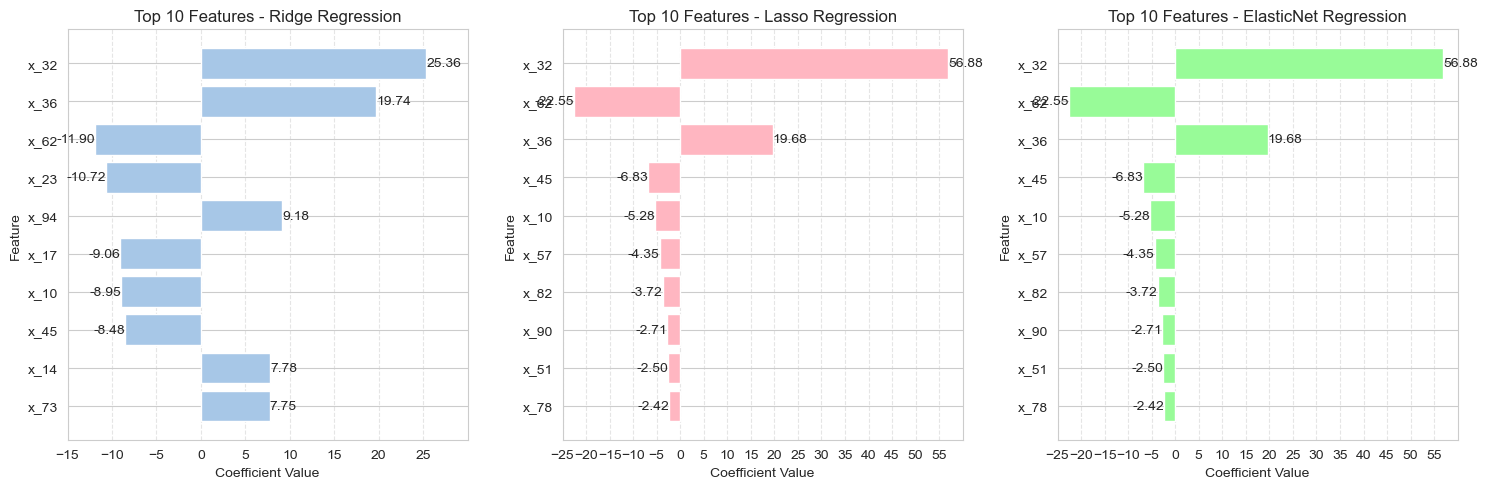

In [211]:
# Feature names (assuming Xtrain is a DataFrame, otherwise use indices)
feature_names = Xtrain.columns

def get_top_features(model):
    """Extract top 10 features based on absolute weight values."""
    coef = model.coef_
    abs_coef = np.abs(coef)
    
    # Get indices of top 10 features
    top_indices = np.argsort(abs_coef)[-10:]  # Top 10 by absolute magnitude
    
    # Get feature names and corresponding values
    top_features = [feature_names[i] for i in top_indices]
    top_values = coef[top_indices]
    
    return top_features, top_values

# Get top features for each model
ridge_features, ridge_values = get_top_features(ridge)
lasso_features, lasso_values = get_top_features(lasso)
en_features, en_values = get_top_features(en)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Use Seaborn style for pastel aesthetics
sns.set_style("whitegrid")

# Define pastel colors
colors = ["#A7C7E7", "#FFB6C1", "#98FB98"]  # Pastel Blue, Pastel Pink, Pastel Green

# Function to plot bars with values on top
def plot_feature_importance(ax, features, values, title, color, xlim_range):
    ax.barh(features, values, color=color)
    ax.set_title(title)
    ax.set_xlabel("Coefficient Value")
    ax.set_ylabel("Feature")
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    ax.set_xlim(xlim_range[0], xlim_range[1])
    ax.set_xticks(np.arange(xlim_range[0], xlim_range[1], 5))

    # Add value labels
    for i, v in enumerate(values):
        ax.text(v, i, f"{v:.2f}", va='center', ha="left" if v > 0 else "right", fontsize=10)

# Plot Ridge
plot_feature_importance(axes[0], ridge_features, ridge_values, "Top 10 Features - Ridge Regression", colors[0], (-15, 30))

# Plot Lasso
plot_feature_importance(axes[1], lasso_features, lasso_values, "Top 10 Features - Lasso Regression", colors[1], (-25, 60))

# Plot ElasticNet
plot_feature_importance(axes[2], en_features, en_values, "Top 10 Features - ElasticNet Regression", colors[2], (-25, 60))

# Adjust layout
plt.tight_layout()
plt.show()